# Setup (imports, constants, etc.)

See scikit-learn [FAQ][1] for multiprocessing issue info fixed below:

[1]:http://scikit-learn.org/stable/faq.html#why-do-i-sometime-get-a-crash-freeze-with-n-jobs-1-under-osx-or-linux

In [59]:
import multiprocessing
import os

start_method = 'forkserver'
try:
    multiprocessing.set_start_method(start_method)
except RuntimeError as e:
    if str(e) != 'context has already been set':
        raise e
    elif multiprocessing.get_start_method() != start_method:
        raise RuntimeWarning(
            'Multiprocessing start_method {} was not set.'
            .format(start_method)
        )

N_JOBS = -1  # for sklearn
NTHREAD = 8  # for xgboost

In [60]:
import glob
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import log_loss
from scipy import stats
from IPython.display import Image, display
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.externals import joblib
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

from main import save_submission, read_rental_interest, to_min_secs
from validation_plots import (
    GridSearchExplorer, best_grid_score, plot_learning_curve
)
from preprocessing import (
    ItemSelector, LatLongImputer, BedBathImputer, feature_prep
)

%matplotlib inline

# Autoreload all imported modules at each execution.
%load_ext autoreload
%autoreload 2

pd.set_option('display.float_format', lambda x: '%.4f' % x)

SEED = 42
np.random.seed(SEED)

DAT_DIR = '../Data/'
SUBM_DIR = '../Submissions/'
TEST_DIR = '../Tests/'
REPORT_IMG_DIR = '../Report-Images/'
TPOT_DIR = './TPOT/'
MODEL_DIR = './Models/'

TRAIN_FP = ''.join([DAT_DIR, 'train.json'])
TEST_FP = ''.join([DAT_DIR, 'test.json'])
SAMPLE_FP = ''.join([DAT_DIR, 'sample_submission.csv'])
DF_TRAIN_PKL = ''.join([DAT_DIR, 'df_train.pkl'])
DF_TEST_PKL = ''.join([DAT_DIR, 'df_test.pkl'])

SPOT_CHECK_LR_FP = ''.join([MODEL_DIR, 'spot-check-lr-model.pkl'])
SPOT_CHECK_XGB_FP = ''.join([MODEL_DIR, 'spot-check-xgb-model.pkl'])

GRID_S2_FP = ''.join([MODEL_DIR, 'grid_s2.pkl'])
GRID_S4_FP = ''.join([MODEL_DIR, 'grid_s4.pkl'])
GRID_S5_FP = ''.join([MODEL_DIR, 'grid_s5.pkl'])
GRID_FREE_FORM_FP = ''.join([MODEL_DIR, 'grid_free_form.pkl'])
FINAL_MODEL_FP = ''.join([MODEL_DIR, 'final-xgb-model.pkl'])

# Using built-in 'neg_log_loss' scoring param used for simplicity
# Source code shows exact same make_scorer call, kept for reference
scorer = make_scorer(log_loss, greater_is_better=False,
                     needs_proba=True)

scoring = 'neg_log_loss'

df = read_rental_interest(DF_TRAIN_PKL)
df_te = read_rental_interest(DF_TEST_PKL)

if DF_TRAIN_PKL not in glob.glob(DAT_DIR+'*'):
    dump_pickle(df, DF_TRAIN_PKL)
if DF_TEST_PKL not in glob.glob(DAT_DIR+'*'):
    dump_pickle(df_te, DF_TEST_PKL)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Benchmark

In [2]:
df = read_rental_interest(DF_TRAIN_PKL)
y = LabelBinarizer().fit_transform(df.interest_level)

avg_probs = (np.sum(y, axis=0)/len(y)).tolist()
baseline_pred = np.array(avg_probs*len(y)).reshape(-1, 3)
baseline_score = log_loss(y, baseline_pred)
print('benchmark score: {:.4f}'.format(baseline_score))

benchmark score: 0.7886


Output:
```
benchmark score: 0.7886
```

# Spot-Check

Basic features:
- Price (logged), Bedrooms, Bathrooms, Latitude, Longitude
- Binarized day created (Monday, Tuesday, etc.)
- Number of photos, features and description word count
- Indicator variables for zero values of counts above (ignored by XGBoost)

In [4]:
features = [
    'price_lg', 'bedrooms', 'bathrooms', 'latitude', 'longitude',
    'n_photos_sq', 'n_feats_sq', 'descr_wcnt_sq',  # count aggregates
    'day_mon', 'day_tue', 'day_wed', 'day_thu',    # day dummies
    'day_fri', 'day_sat', 'day_sun',
]

df = read_rental_interest(DF_TRAIN_PKL)

X, y = df.drop('interest_level', axis=1), df.interest_level

X_prepped_noimp = feature_prep(X).loc[:, features]

X_train_noimp, X_test_noimp, y_train_noimp, y_test_noimp = train_test_split(
    X_prepped_noimp, y, random_state=SEED, stratify=y, test_size=.25,
)

# labels are reduced by one to match num_label format in xgb
dtrain_noimp = xgb.DMatrix(X_train_noimp, y_train_noimp-1,
                           feature_names=features)
dtest_noimp  = xgb.DMatrix(X_test_noimp, y_test_noimp-1,
                           feature_names=features)

## Logistic Regression  Spot Check

Loaded: ./Models/spot-check-lr-model.pkl


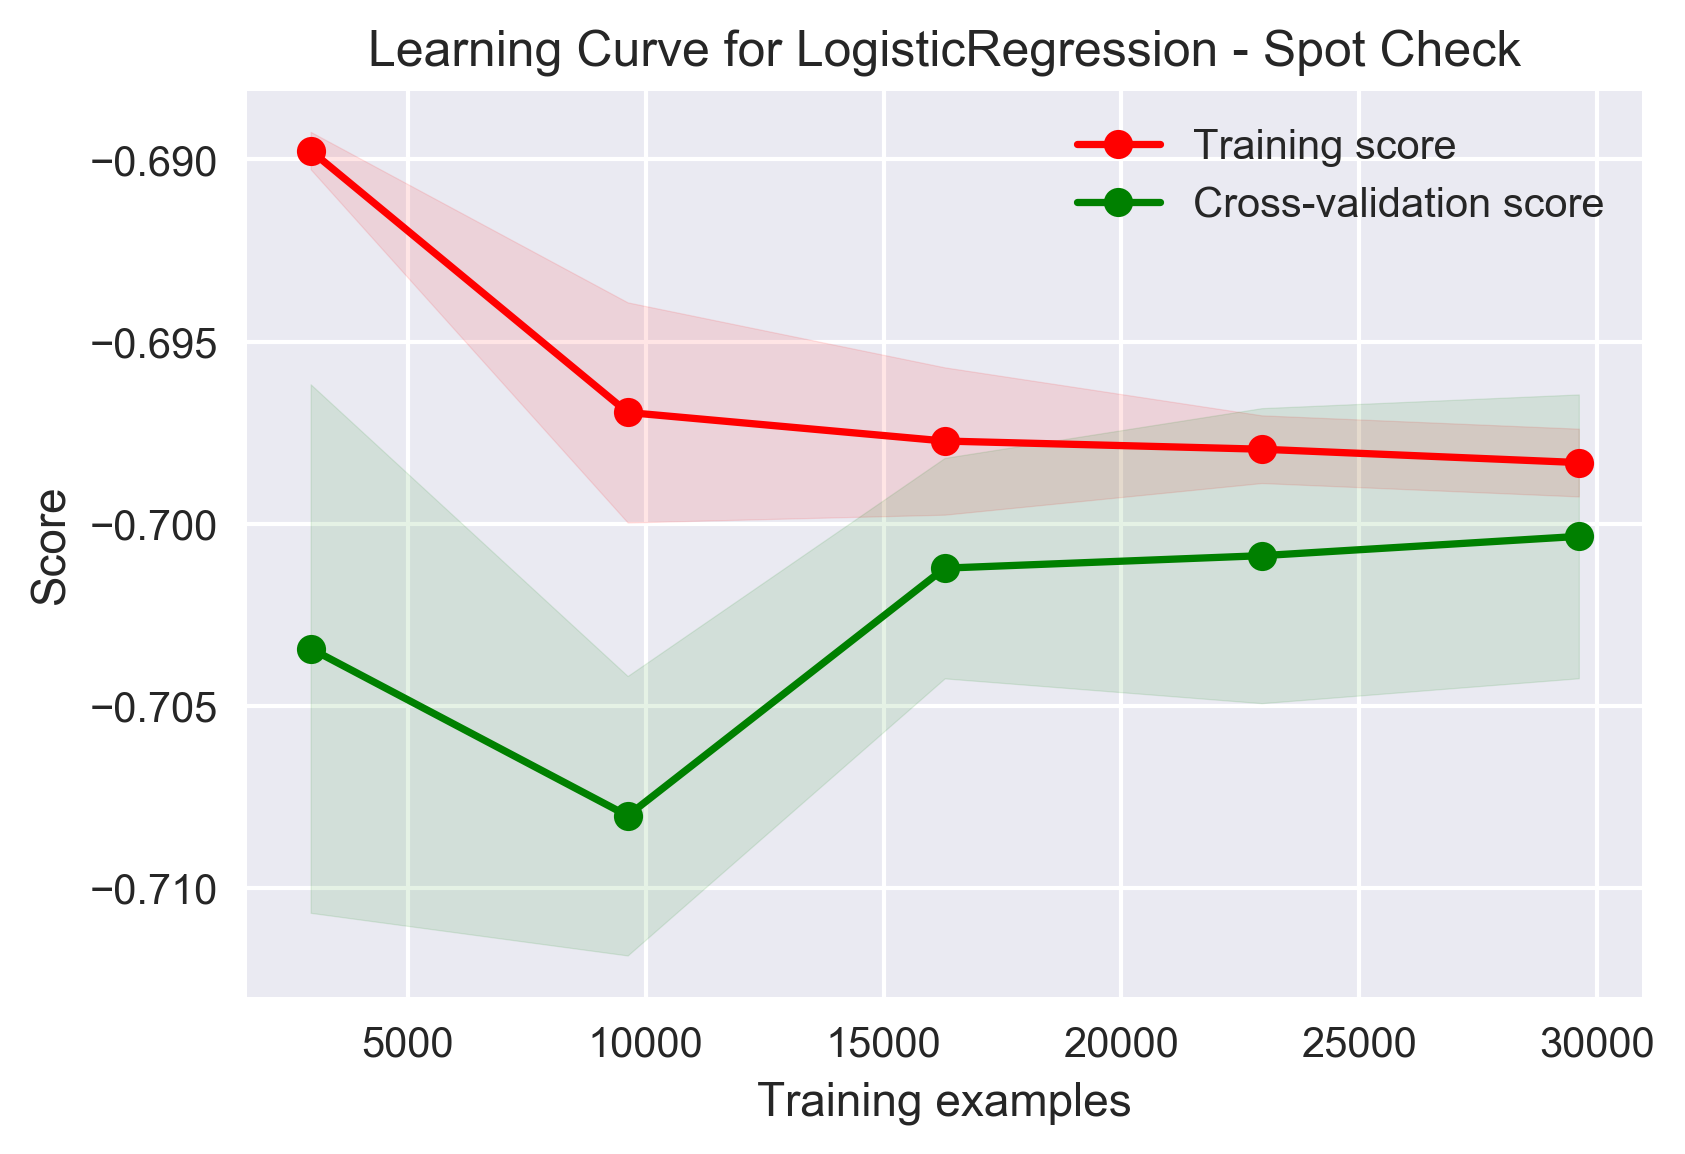

In [69]:
fp = ''.join([REPORT_IMG_DIR, 'spchk-lr-learning-curve.png'])

RUN_LR = False

if RUN_LR:

    lr_spot = LogisticRegression(multi_class='multinomial', solver='lbfgs',
                                 n_jobs=1, random_state=SEED)

    pipe = Pipeline([
        ('standardize', StandardScaler()),
        ('lr_spot', lr_spot)
    ])

    params = dict(
        lr_spot__C=np.logspace(-4, 4, 9),
    )
    grid = GridSearchCV(pipe, params, n_jobs=N_JOBS, scoring=scoring, cv=5)

    %timeit -r1 -n1 grid.fit(X_train_noimp, y_train_noimp)

    print()
    print(best_grid_score(grid))
    print()

    lr_spot = grid.best_estimator_

    # kwargs so %timeit works with multiline arguments
    kwargs = dict(estimator=lr_spot, X=X_train_noimp, y=y_train_noimp,
                  estimator_name='LogisticRegression - Spot Check',
                  scoring=scoring, n_jobs=N_JOBS)

    %timeit -r1 -n1 plot_learning_curve(**kwargs)
    
#     joblib.dump(lr_spot, SPOT_CHECK_LR_FP)
#     print()
#     print('Pickled to: {}'.format(SPOT_CHECK_LR_FP))

    # plt.savefig(fp, dpi=300, bbox_inches='tight')
    
else:
    lr_spot = joblib.load(SPOT_CHECK_LR_FP)
    print('Loaded: {}'.format(SPOT_CHECK_LR_FP))
    
    display(Image(fp, width=500))

Output:
```
8.03 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)

Best grid CV score: -0.7003 ± 0.0039 (mean ± std. dev.)
Train score:        -0.6984 ± 0.0010 (mean ± std. dev.)

*** For parameters: ***
lr_spot__C=0.1

4.98 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)

Pickled to: ./Models/spot-check-lr-model.pkl
```

## XGBoost Spot Check

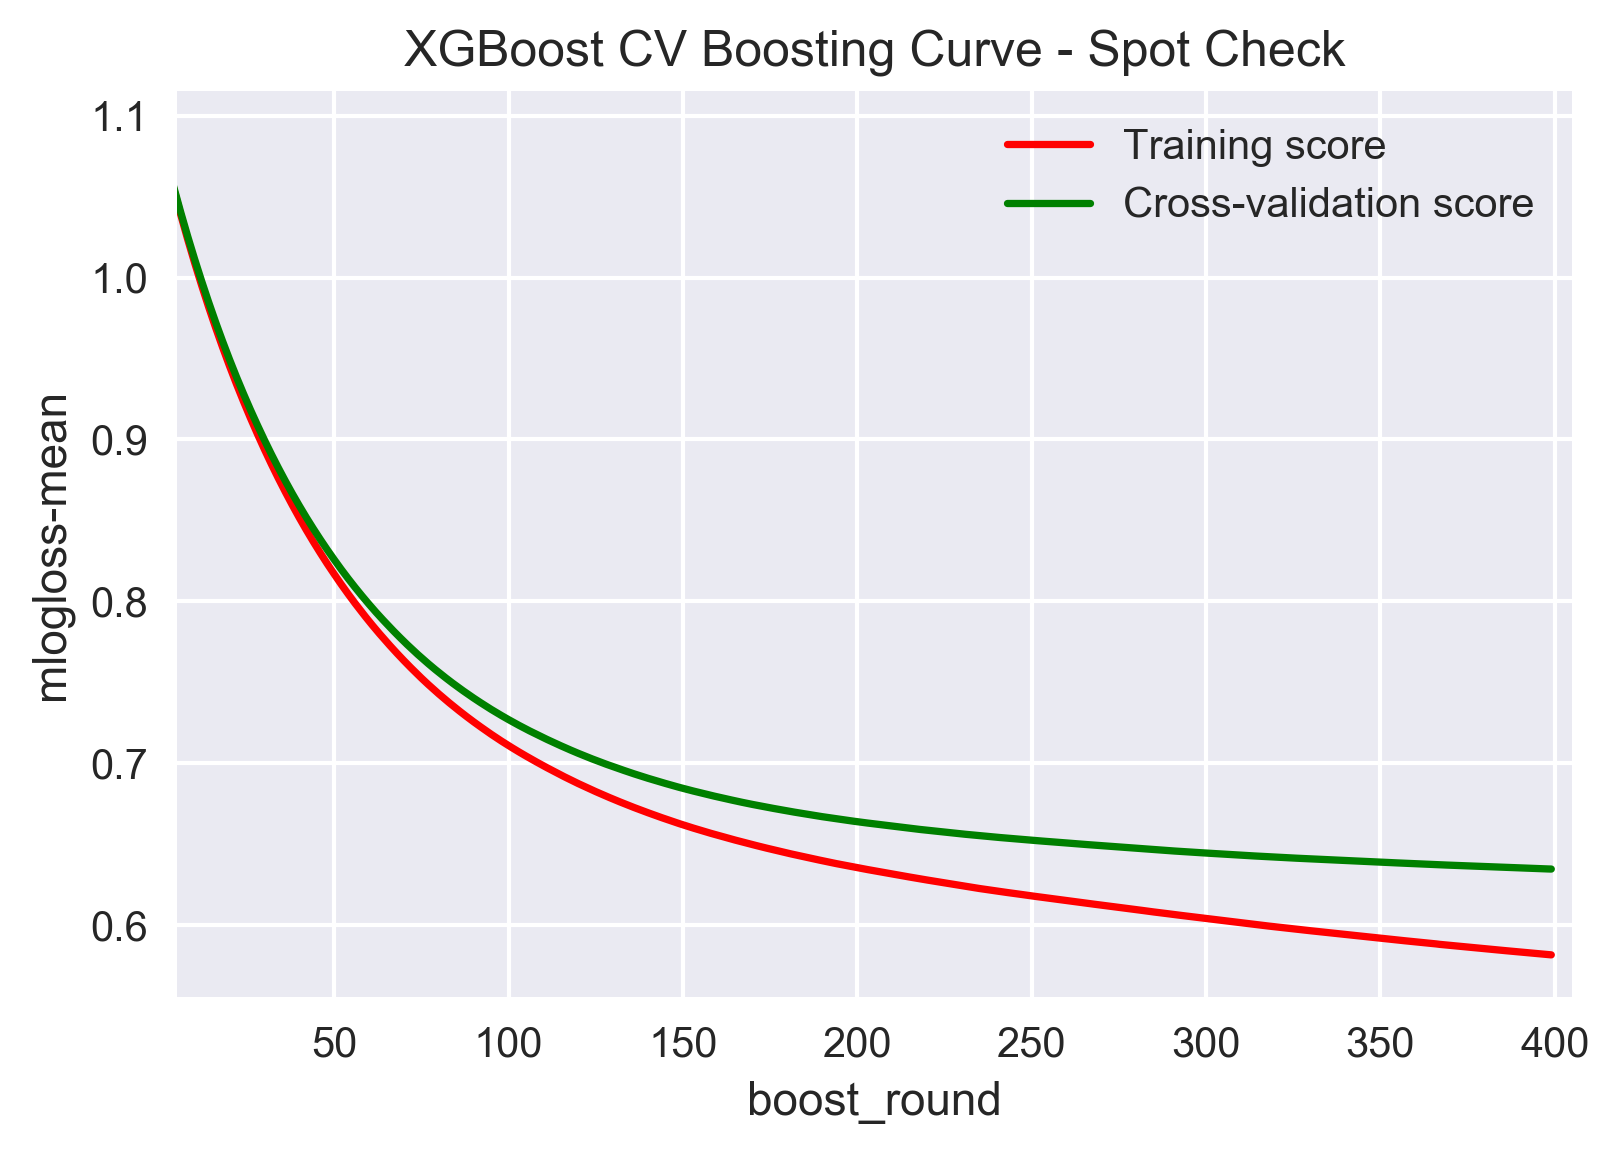

In [72]:
RUN_XGB = False
fp = ''.join([REPORT_IMG_DIR, 'spchk-xgb-boosting-curve.png'])

if RUN_XGB:

    learning_rate = 0.015
    n_estimators = 400
    max_depth = 6

    params = dict(
        objective='multi:softprob',
        
        learning_rate=learning_rate,  # low bias model, using 5/n-rounds
        max_depth=max_depth,
        
        num_class=3, silent=True,
        nthread=NTHREAD, seed=SEED,
    )

    start = time.time()
    eval_hist = xgb.cv(
        params, dtrain_noimp,
        
        num_boost_round=n_estimators,
        verbose_eval=50,
        
        metrics='mlogloss',
        seed=SEED, stratified=True, nfold=3,
    )

    end = time.time()
    print()
    print('Runtime: {}min {}s'.format(*to_min_secs(end-start)))
    print()
    print(best_xgb_cv_score(eval_hist))
    
    ax = plot_xgb_boosting_curve(eval_hist)
    ax.set_xlim(5, n_estimators+5)
    ax.set_title(ax.get_title() + ' - Spot Check')
#     plt.savefig(fp, dpi=300, bbox_inches='tight')
    
else:    
    display(Image(fp, width=500))

Output:
```
[0]	train-mlogloss:1.08943+2.05318e-05	test-mlogloss:1.08964+1.7442e-05
[50]	train-mlogloss:0.816855+0.00070567	test-mlogloss:0.825788+0.000372252
[100]	train-mlogloss:0.710921+0.00105693	test-mlogloss:0.726957+0.000436776
[150]	train-mlogloss:0.661974+0.00100593	test-mlogloss:0.684497+0.00068228
[200]	train-mlogloss:0.635471+0.000748557	test-mlogloss:0.663879+0.000741124
[250]	train-mlogloss:0.618083+0.000790681	test-mlogloss:0.652458+0.000839083
[300]	train-mlogloss:0.604073+0.000705637	test-mlogloss:0.644524+0.000842528
[350]	train-mlogloss:0.591965+0.000727832	test-mlogloss:0.638927+0.00097023

Runtime: 1min 20s

Best CV score (round 399):  0.6346 ± 0.0013 (mean ± std. dev.)
Train score (round 399):    0.5816 ± 0.0007 (mean ± std. dev.)
```

Runtime: 1min 5s


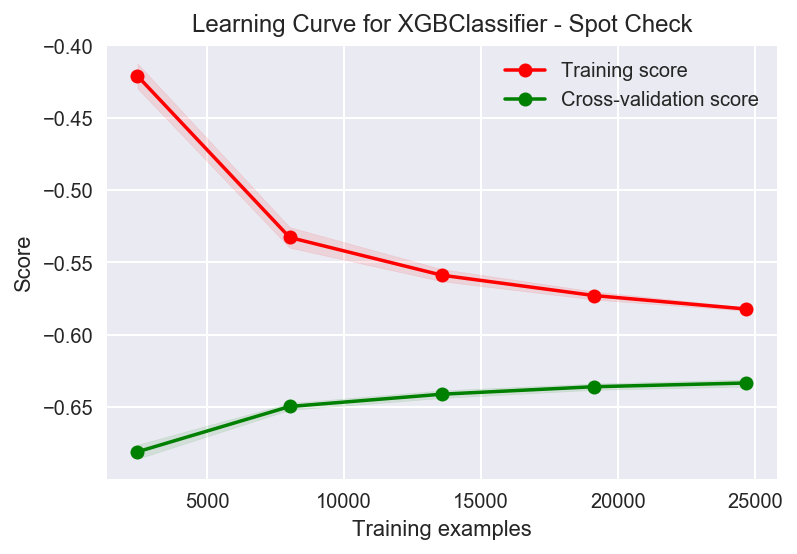

In [71]:
fp = ''.join([REPORT_IMG_DIR, 'spchk-xgb-learning-curve.png'])

if RUN_XGB:
    xgb_clf = XGBClassifier(
        objective='multi:softprob',
        
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        max_depth=max_depth,
        
        nthread=NTHREAD, seed=SEED,
    )
    start = time.time()
    plot_learning_curve(
        estimator=xgb_clf, X=X_train_noimp, y=y_train_noimp,
        estimator_name='XGBClassifier - Spot Check',
        scoring=scoring, n_jobs=N_JOBS,
    )
    end = time.time()
    
    print('Runtime: {}min {}s'.format(*to_min_secs(end-start)))
    
#     plt.savefig(fp, dpi=300, bbox_inches='tight')

    xgb_clf.fit(X_train_noimp, y_train_noimp)
#     joblib.dump(xgb_clf, SPOT_CHECK_XGB_FP)
#     print('Pickled to: {}'.format(SPOT_CHECK_XGB_FP))
    
else:
    xgb_clf = joblib.load(SPOT_CHECK_XGB_FP)
    print('Loaded: {}'.format(SPOT_CHECK_XGB_FP))
    display(Image(fp, width=500))

Output:
```
Runtime: 1min 25s
```

## TPOT

In [19]:
if 1 == 0:

    tpot_light = TPOTClassifier(
        generations=5, population_size=20, verbosity=2,
        scoring='neg_log_loss', random_state=SEED, n_jobs=1,
        config_dict=''.join([TPOT_DIR, 'classifier_light.py'])
    )
    tpot_light.fit(X_train, y_train)
    tpot_light.export(''.join([TPOT_DIR, 'tpot_bench_light.py']))
    pickle.dump(tpot_light, ''.join([TPOT_DIR, 'tpot_bench_light.pkl']))

Output:
```
Generation 5 - Current best internal CV score: 0.6708706420692458

Best pipeline: LogisticRegression(DecisionTreeClassifier(StandardScaler(input_matrix), DecisionTreeClassifier__criterion=DEFAULT, DecisionTreeClassifier__max_depth=10, DecisionTreeClassifier__min_samples_leaf=19, DecisionTreeClassifier__min_samples_split=17), LogisticRegression__C=25.0, LogisticRegression__dual=DEFAULT, LogisticRegression__penalty=DEFAULT)
```

In [18]:
if 1 == 0:
    tpot = TPOTClassifier(generations=5, population_size=20, verbosity=2,
                          scoring=scoring, random_state=SEED, n_jobs=1,
    )
    %timeit -r1 -n1 tpot.fit(X_train, y_train)
    tpot.export(''.join([TPOT_DIR, 'tpot_bench.py']))
    pickle.dump(tpot, ''.join([TPOT_DIR, 'tpot_bench.pkl']))

Output:
```
Generation 5 - Current best internal CV score: 0.6185133810756033

Best pipeline: XGBClassifier(input_matrix, XGBClassifier__learning_rate=DEFAULT, XGBClassifier__max_depth=6, XGBClassifier__min_child_weight=4, XGBClassifier__n_estimators=100, XGBClassifier__n_jobs=1, XGBClassifier__subsample=0.45)
51min 2s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
```

# Model Refinement

__Parameter Notes__

- For imbalanced classes and speed
    - `scale_pos_weigh`, [default=1] (faster, no effect on score)
        - See speed improvement section for details
    - `max_delta_step`, [default=0]
        - From overfitting guide: If you care about predicting the right probability
In such a case, you cannot re-balance the dataset
In such a case, set parameter `max_delta_step` to a finite number (say 1) will help convergence
        - From docs: Maximum delta step we allow each tree's weight estimation to be. If the value is set to 0, it means there is no constraint. If it is set to a positive value, it can help making the update step more conservative. Usually this parameter is not needed, but it might help in logistic regression when class is extremely imbalanced. Set it to value of 1-10 might help control the update

In [74]:
# Same as spot-check data, just with missing data val -999 imputed

features = [
    'price_lg', 'bedrooms', 'bathrooms', 'latitude', 'longitude',
    'n_photos_sq', 'n_feats_sq', 'descr_wcnt_sq',  # count aggregates
    'day_mon', 'day_tue', 'day_wed', 'day_thu',    # day dummies
    'day_fri', 'day_sat', 'day_sun',
]

df = read_rental_interest(DF_TRAIN_PKL)

X, y = df.drop('interest_level', axis=1), df.interest_level


X_prepped = feature_prep(X, imp_constant=-999).loc[:, features]

X_train, X_test, y_train, y_test = train_test_split(
    X_prepped, y, random_state=SEED, stratify=y, test_size=.25,
)

# labels are reduced by one to match num_label format in xgb
dtrain = xgb.DMatrix(X_train, y_train-1, feature_names=features,
                     missing=-999)
dtest  = xgb.DMatrix(X_test, y_test-1, feature_names=features,
                     missing=-999)

## Stage 1: Assess XGBoost's missing value handling

In [73]:
RUN_XGB = False

if RUN_XGB:
    
    # Same as spot-checked
    learning_rate = 0.015
    n_estimators = 400
    max_depth = 6
    
    xgb_clf = XGBClassifier(
        objective='multi:softprob',
        
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        max_depth=max_depth,
        
        missing=-999, nthread=1, seed=SEED,
    )
    
    start = time.time()
    scores = cross_val_score(
        estimator=xgb_clf, X=X_train, y=y_train,
        fit_params=dict(eval_metric='mlogloss'),
        cv=3, scoring=scoring, n_jobs=N_JOBS,
    )
    y_pred = xgb_clf.fit(X_train, y_train).predict_proba(X_train)
    end = time.time()
    print('Runtime: {}min {}s'.format(*to_min_secs(end-start)))
    print()
    print('Mean CV score: {:>10.4f}'.format(np.mean(scores)))
    print('Train score:   {:>10.4f}'.format(-log_loss(y_train, y_pred)))


Runtime: 1min 14s

Mean CV score:    -0.6327
Train score:      -0.5916


Output:
```
Runtime: 1min 17s

Mean CV score:    -0.6327
Train score:      -0.5916
```

From [docs on tuning](https://github.com/dmlc/xgboost/blob/master/doc/how_to/param_tuning.md):
- Controls complexity:
    - max_depth
    - gamma
    - min_child_weight

- Robustness to noise:
    - sample_bytree (tune before subsample)
    - subsample 

From [docs on parameters](https://github.com/dmlc/xgboost/blob/master/doc/parameter.md):

- gamma [default=0, alias: min_split_loss]
    - minimum loss reduction required to make a further partition on a leaf node of the tree. The larger, the more conservative the algorithm will be.
    - range: [0,∞]

- max_depth [default=6]
    - maximum depth of a tree, increase this value will make the model more complex / likely to be overfitting. 0 indicates no limit, limit is required for depth-wise grow policy.
    - range: [0,∞]

- colsample_bytree [default=1]
    - subsample ratio of columns when constructing each tree.
    - range: (0,1]

## Stage 2: Tune `max_depth`, `colsample_bytree` and `gamma`

3min 57s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)



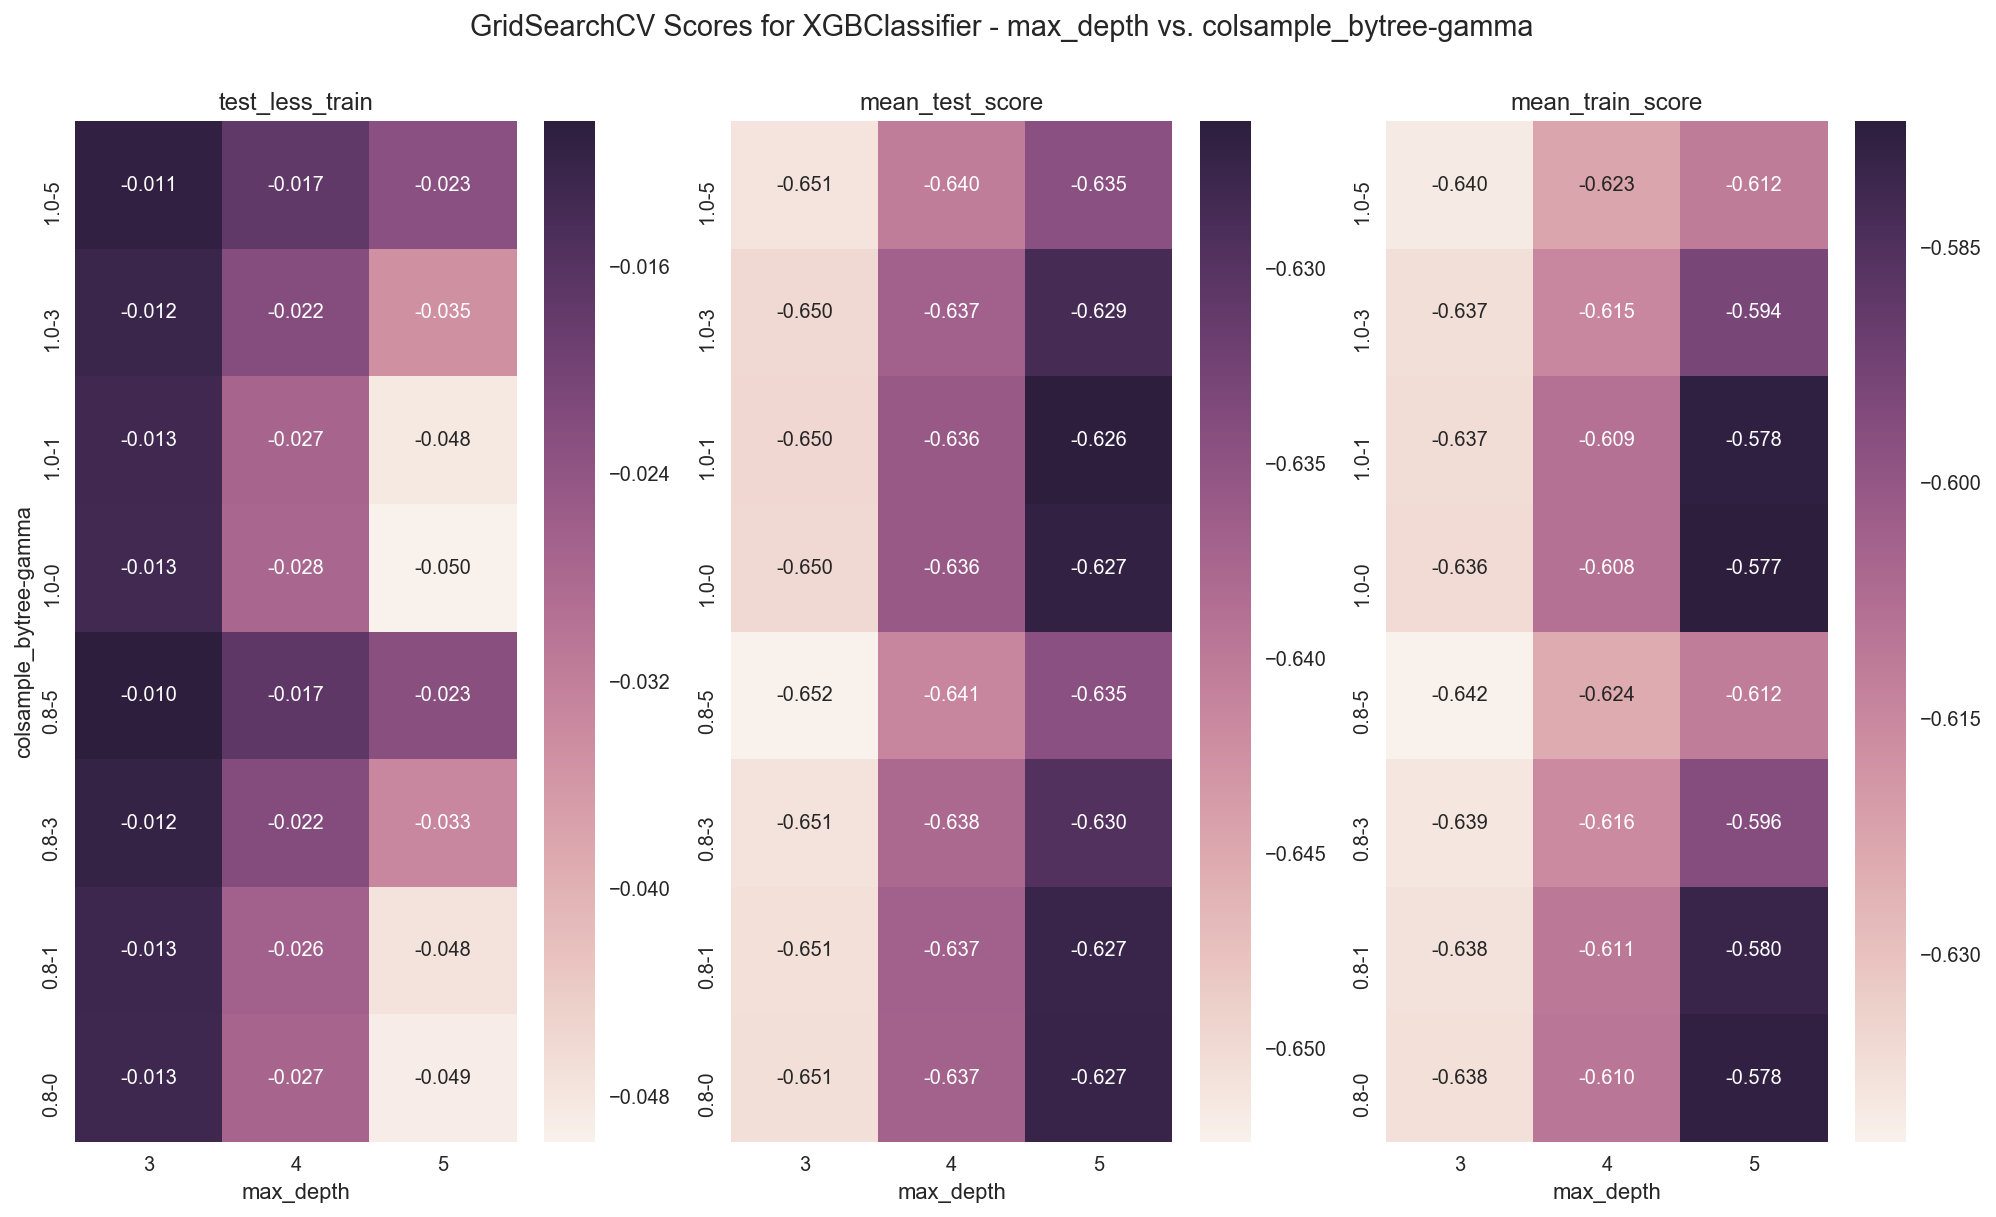

In [75]:
GRID_S2_FP = ''.join([MODEL_DIR, 'grid_s2.pkl'])

RUN_XGB = False

if RUN_XGB:
    
    # Same as for missing value evaluation
    learning_rate = 0.05
    n_estimators = 200
    
    max_depth = [3, 4, 5]
    gamma = [0, 1, 3, 5]
    colsample_bytree = [.8, 1]
    
    
    xgb_clf = XGBClassifier(
        objective='multi:softprob',
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        
        missing=-999, nthread=1, seed=SEED,
        
    )
    params = dict(
        max_depth=max_depth,
        gamma=gamma,
        colsample_bytree=colsample_bytree,
    )
    
    fit_params=dict(
        early_stopping_rounds=3, 
        eval_metric='mlogloss', 
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=False,
    )
    grid_s2 = GridSearchCV(xgb_clf, params, fit_params=fit_params,
                           scoring=scoring, cv=3, n_jobs=N_JOBS)

    %timeit -r1 -n1 grid_s2.fit(X_train, y_train)
    print()
    
#     joblib.dump(grid_s2, GRID_S2_FP)
#     print('Pickled to: {}'.format(GRID_S2_FP))
    
else:
    grid_s2 = joblib.load(GRID_S2_FP)
    print('Loaded: {}'.format(GRID_S2_FP))
    
ge = GridSearchExplorer(grid_s2)
fig = ge.plot_cv_train_comparison(x='max_depth', figsize=(14, 8))

suptitle = ('GridSearchCV Scores for XGBClassifier'
            ' - max_depth vs. colsample_bytree-gamma')
plt.suptitle(suptitle, fontsize='x-large', y=1.05)

plt.tight_layout()

Output:
```
3min 40s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
```

In [77]:
res = pd.DataFrame(grid_s2.cv_results_)
res = (res.iloc[:, [2, 3, 4, 5, 6]]
          .assign(diff=res.iloc[:, 2]-res.iloc[:, 3])
          .sort_values('mean_test_score', ascending=False)
)
res.head(10)

,mean_test_score,mean_train_score,param_colsample_bytree,param_gamma,param_max_depth,diff
17,-0.6262,-0.5777,1,1,5,-0.0485
14,-0.6268,-0.5770,1,0,5,-0.0498
2,-0.6273,-0.5782,0.8000,0,5,-0.0491
5,-0.6274,-0.5798,0.8000,1,5,-0.0476
20,-0.6285,-0.5938,1,3,5,-0.0348
8,-0.6296,-0.5963,0.8000,3,5,-0.0333
23,-0.6345,-0.6116,1,5,5,-0.0230
11,-0.6346,-0.6120,0.8000,5,5,-0.0226
16,-0.6359,-0.6087,1,1,4,-0.0272
13,-0.6359,-0.6084,1,0,4,-0.0276


In [78]:
best_res = res.loc[[11]]
best_res

,mean_test_score,mean_train_score,param_colsample_bytree,param_gamma,param_max_depth,diff
11,-0.6346,-0.6120,0.8000,5,5,-0.0226


### Conclusion:
Updating parameters with best from above will lower model variance significantly enough

```
objective='multi:softprob',
n_estimators = 200,
learning_rate=0.05,

max_depth=5, 
gamma=5, 
colsample_bytree=.8,

missing=-999, nthread=NTHREAD, seed=SEED,
num_class=3
```

## Stage 3: Tune `n_estimators`

Runtime: 0min 25s



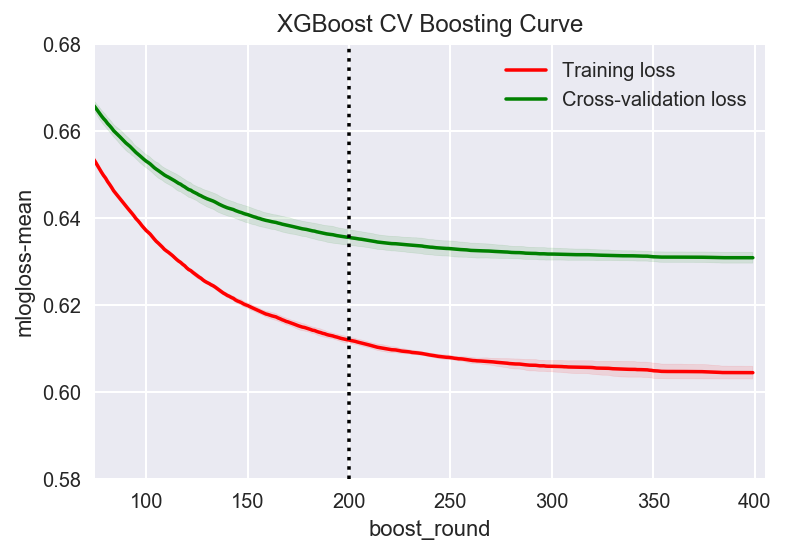

,test-mlogloss-mean,train-mlogloss-mean,diff
199,0.6355,0.6119,0.0236
249,0.6329,0.6079,0.0250
299,0.6316,0.6058,0.0258
349,0.6310,0.6049,0.0262
399,0.6308,0.6043,0.0264


In [79]:
params = dict(
    objective='multi:softprob',
    n_estimators = 400,  # specified in xgb.cv params
    learning_rate=0.05,
    
    # best from above
    max_depth=5, 
    gamma=5, 
    colsample_bytree=.8,
    
    missing=-999, nthread=NTHREAD, seed=SEED,
    num_class=3
)

start = time.time()

eval_hist = xgb.cv(params, dtrain, num_boost_round=400, 
                   stratified=True, early_stopping_rounds=25,
                   metrics='mlogloss', seed=SEED, nfold=3)

end = time.time()
print('Runtime: {}min {}s\n'.format(*to_min_secs(end-start)))

ax = plot_xgb_boosting_curve(eval_hist)
ax.plot([200, 200], [.58, .68], 'k:')
ax.set_xlim(75, 405)
ax.set_ylim(.58, .68)

fp = ''.join([REPORT_IMG_DIR, 'tune-est-xgb-boosting-curve.png'])
# plt.savefig(fp, dpi=300, bbox_inches='tight') 

plt.show()

n_estim_idx = [199, 249, 299, 349, 399]
estim_eval = (eval_hist.iloc[n_estim_idx, [0, 2]]
                       .assign(diff=eval_hist.iloc[n_estim_idx, 0] 
                               - eval_hist.iloc[n_estim_idx, 2])
)
display(estim_eval)

Output:
```
Runtime: 0min 25s
```

### Conclusion:
- Keep number of estimators at 200

## Stage 4: Tune `max_depth` and `min_child_weight`

From [docs on parameters](https://github.com/dmlc/xgboost/blob/master/doc/parameter.md)

min_child_weight [default=1]
- minimum sum of instance weight (hessian) needed in a child. If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, then the building process will give up further partitioning. In linear regression mode, this simply corresponds to minimum number of instances needed to be in each node. The larger, the more conservative the algorithm will be.
- range: [0,∞]

3min 44s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)

Best grid CV score: -0.6280 ± 0.0022 (mean ± std. dev.)
Train score:        -0.5939 ± 0.0023 (mean ± std. dev.)

*** For parameters: ***
max_depth=7
min_child_weight=4


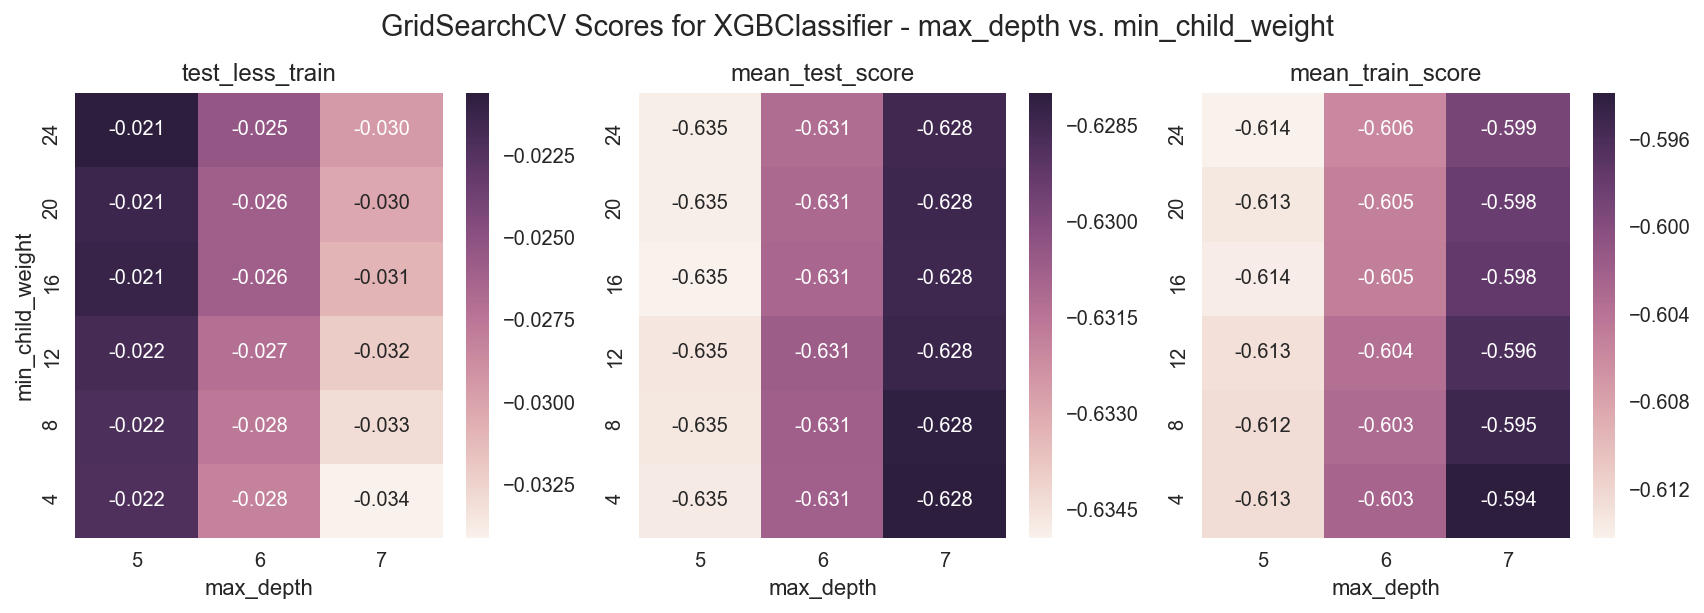

In [80]:
RUN_XGB = False

if RUN_XGB:
    
    xgb_clf = XGBClassifier(
        objective='multi:softprob',
        n_estimators=200,
        learning_rate=0.05,
        
        max_depth=5,
        gamma=5, 
        colsample_bytree=.8,
        
        missing=-999, nthread=1, seed=SEED,
    )
    params = dict(
        min_child_weight=[4, 8, 12, 16, 20, 24],
        max_depth=[5, 6, 7],
    )
    
    fit_params=dict(
        eval_metric='mlogloss',
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=False,
    )
    grid_s4 = GridSearchCV(xgb_clf, params, fit_params=fit_params,
                           scoring=scoring, cv=3, n_jobs=N_JOBS)

    %timeit -r1 -n1 grid_s4.fit(X_train, y_train)
    print()
    
#     joblib.dump(grid_s4, GRID_S4_FP)
#     print('Pickled to: {}'.format(GRID_S4_FP))
    
else:
    grid_s4 = joblib.load(GRID_S4_FP)
    print('Loaded: {}'.format(GRID_S4_FP))
    
print(best_grid_score(grid_s4))

ge = GridSearchExplorer(grid_s4)
fig = ge.plot_cv_train_comparison(x='max_depth')

suptitle = ('GridSearchCV Scores for XGBClassifier'
            ' - max_depth vs. min_child_weight')
plt.suptitle(suptitle, fontsize='x-large', y=1.05)

plt.tight_layout()

Output:
```
5min 18s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)

Pickled to: ./Models/grid_s2.pkl
Best grid CV score: -0.6280 ± 0.0022 (mean ± std. dev.)
Train score:        -0.5939 ± 0.0023 (mean ± std. dev.)

*** For parameters: ***
max_depth=7
min_child_weight=4
```

In [81]:
res = pd.DataFrame(grid_s4.cv_results_)
res = (res.iloc[:, [2, 3, 4, 5]]
          .assign(diff=res.iloc[:, 2]-res.iloc[:, 3])
          .sort_values('mean_test_score', ascending=False)
)
res.head(10)

,mean_test_score,mean_train_score,param_max_depth,param_min_child_weight,diff
12,-0.6280,-0.5939,7,4,-0.0341
13,-0.6280,-0.5951,7,8,-0.0329
14,-0.6284,-0.5963,7,12,-0.0321
16,-0.6284,-0.5982,7,20,-0.0302
15,-0.6284,-0.5976,7,16,-0.0309
17,-0.6285,-0.5990,7,24,-0.0295
8,-0.6307,-0.6036,6,12,-0.0271
7,-0.6307,-0.6031,6,8,-0.0276
6,-0.6308,-0.6026,6,4,-0.0282
9,-0.6310,-0.6051,6,16,-0.0259


### Conclusion:

Best balance is `max_depth=6`, `min_child_weight=8`: 
- `0.6307 - 0.6036 = 0.0271`

No improvement on previous stage:
- `0.6329 - 0.6118 = 0.0211`

## Stage 5: Reassess XGBoost's missing value handling

In [82]:
features = [
    'price_lg', 'bedrooms', 'bathrooms', 'latitude', 'longitude',
    'n_photos_sq', 'n_feats_sq', 'descr_wcnt_sq',  # count aggregates
    'day_mon', 'day_tue', 'day_wed', 'day_thu',    # day dummies
    'day_fri', 'day_sat', 'day_sun',
]

X_prepped_noimp = feature_prep(X).loc[:, features]

X_train_noimp, X_test_noimp, y_train_noimp, y_test_noimp = \
    train_test_split(
        X_prepped_noimp, y, random_state=SEED, stratify=y, test_size=.25,
    )

In [83]:
# Prevents occasional pickle error within GridSearch after autoreload
from preprocessing import ItemSelector, LatLongImputer, BedBathImputer

RUN_XGB = False

if RUN_XGB:
    
    # Multithreading must take place in XGBoostClassifier to prevent:
    # AttributeError: 'BedBathImputer' object has no attribute 'imp_constant'
    xgb_clf = XGBClassifier(
            objective='multi:softprob',
            n_estimators=200,
            learning_rate=0.05,

            max_depth=5,
            gamma=5, 
            colsample_bytree=.8,

            missing=-999, nthread=NTHREAD, seed=SEED,
    )
    
    extractor = FeatureUnion([
        ('pre_processed', ItemSelector(
            ['price_lg', 'n_photos_sq', 'n_feats_sq', 'descr_wcnt_sq']
            )
        ),
        ('coords', Pipeline([
            ('select', ItemSelector(['latitude', 'longitude'])),
            ('imp_coords', LatLongImputer(how='mean', broad=False)),
            ])
        ),
        ('rooms', Pipeline([
            ('select', ItemSelector(['bathrooms', 'bedrooms'])),
            ('imp_rooms', BedBathImputer(how='medians')),
            ])
        ),   
        ('days', ItemSelector([
            'day_mon', 'day_tue', 'day_wed', 'day_thu',
            'day_fri', 'day_sat', 'day_sun' 
            ])
        ),
    ])
    
    pipe = Pipeline([
        ('extr', extractor),
        ('xgb_clf', xgb_clf),
    ])
    
    params = dict(
        extr__coords__imp_coords__how=['mean', -999],
        extr__coords__imp_coords__broad=[False, True],
        extr__rooms__imp_rooms__how=['medians', -999],
    )
    
    grid_s5 = GridSearchCV(
        pipe, params, scoring=scoring, cv=3, n_jobs=1
    )
    %timeit -r1 -n1 grid_s5.fit(X_train_noimp, y_train_noimp)
    print()
    
#     joblib.dump(grid_s5, GRID_S5_FP)
#     print('Pickled to: {}'.format(GRID_S5_FP))
    
else:
    grid_s5 = joblib.load(GRID_S5_FP)
    print('Loaded: {}'.format(GRID_S5_FP))
    
print(best_grid_score(grid_s5))


1min 43s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)

Best grid CV score: -0.6345 ± 0.0022 (mean ± std. dev.)
Train score:        -0.6122 ± 0.0015 (mean ± std. dev.)

*** For parameters: ***
extr__coords__imp_coords__broad=False
extr__coords__imp_coords__how=mean
extr__rooms__imp_rooms__how=-999


Output:
```
2min 3s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)

Pickled to: ./Models/grid_s5.pkl
Best grid CV score: -0.6345 ± 0.0022 (mean ± std. dev.)
Train score:        -0.6122 ± 0.0015 (mean ± std. dev.)

*** For parameters: ***
extr__coords__imp_coords__broad=False
extr__coords__imp_coords__how=mean
extr__rooms__imp_rooms__how=-999
```

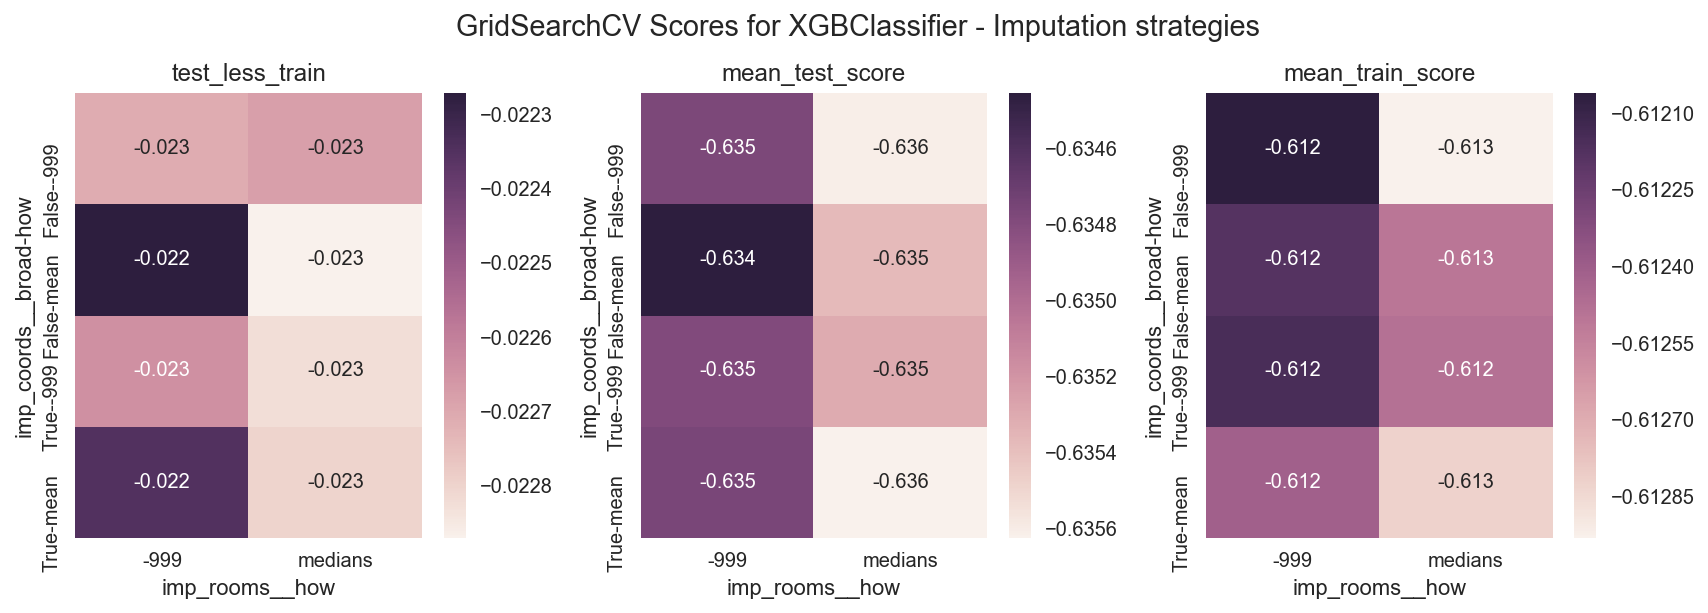

In [87]:
ge = GridSearchExplorer(grid_s5)
fig = ge.plot_cv_train_comparison(x='extr__rooms__imp_rooms__how')

suptitle = ('GridSearchCV Scores for XGBClassifier'
            ' - Imputation strategies')
plt.suptitle(suptitle, fontsize='x-large', y=1.05)
for ax in fig.axes[0:3]:
    ax.set_ylabel('imp_coords__broad-how')
    ax.set_xlabel('imp_rooms__how')

plt.tight_layout()

### Conclusion:

No meaningful difference

## Stage 6: Probability Calibration

In [51]:
def plot_multiclass_calibration_curve(y_true, y_prob, n_bins=10, ax=None):
    
    assert (y_prob.sum(1).round(decimals=5)==1).all()
    
    if ax is None:
        fig, ax = plt.subplots()
    linestyle = 'd-'
        
    ax.plot([0, 1], [0, 1], 'k:', label='Perfectly calibrated')

    y_true1 = y_true.replace([1, 2, 3], [1, 0, 0])
    y_prob1 = y_prob.loc[:, 1]

    fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_true1, y_prob1, n_bins=n_bins)

    ax.plot(mean_predicted_value, fraction_of_positives, linestyle,
            label='low')

    y_true2 = y_true.replace([1, 2, 3], [0, 1, 0])
    y_prob2 = y_prob.loc[:, 2]

    fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_true2, y_prob2, n_bins=n_bins)

    ax.plot(mean_predicted_value, fraction_of_positives, linestyle,
            label='medium')

    y_true3 = y_true.replace([1, 2, 3], [0, 0, 1])
    y_prob3 = y_prob.loc[:, 3]

    fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_true3, y_prob3, n_bins=n_bins)

    ax.plot(mean_predicted_value, fraction_of_positives, linestyle,
            label='high')

    ax.set_xlabel('Mean predicted value')
    ax.set_ylabel('Fraction of positives')
    ax.set_ylim([-0.05, 1.05])
    ax.legend()
    ax.set_title('Calibration plots (reliability curve)')
    
    return ax

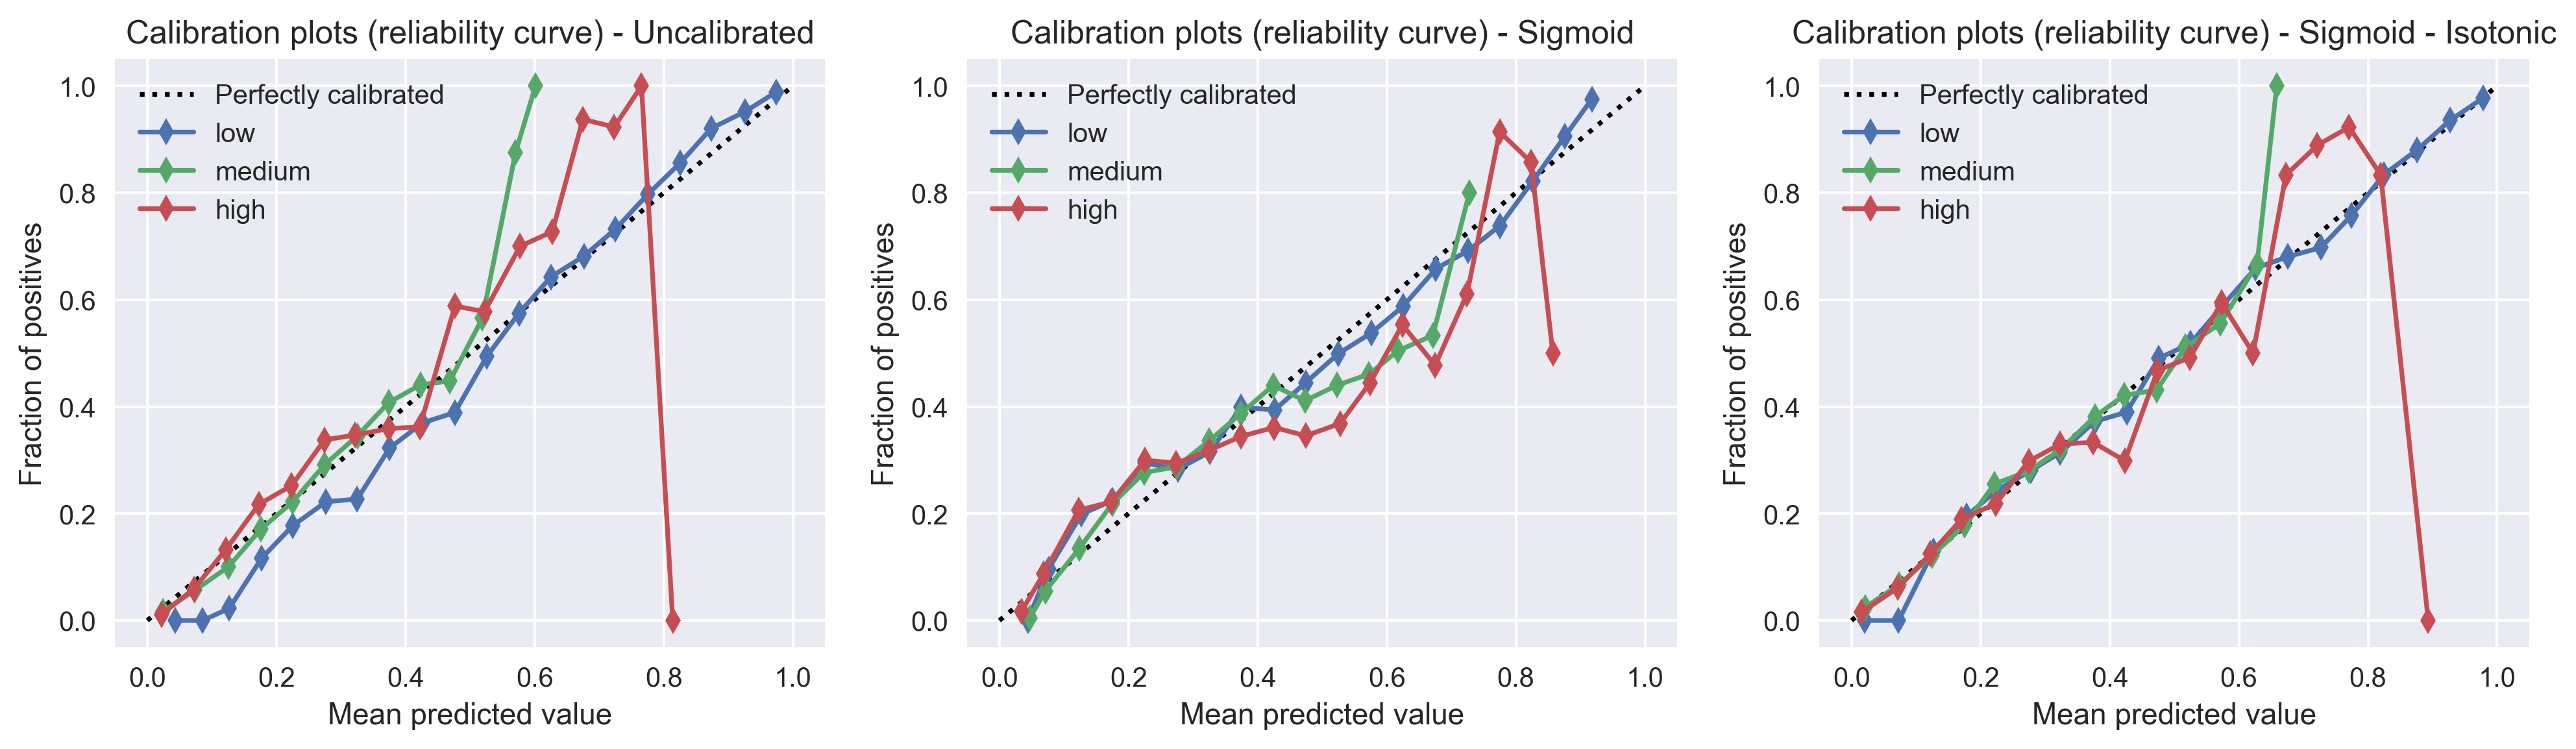

In [63]:
fp = ''.join([REPORT_IMG_DIR, 'xgb-calibration-curve.png'])

RUN_XGB = False

if RUN_XGB:
    
    start = time.time()

    # Resplit for equal disjoint calibration sets
    X_train_calb, X_test_calb, y_train_calb, y_test_calb = train_test_split(
        X_prepped, y, random_state=SEED, stratify=y, test_size=.25,
    )

    xgb_clf = XGBClassifier(
        objective='multi:softprob',
        n_estimators=200,
        learning_rate=0.05,

        max_depth=5,
        gamma=5, 
        colsample_bytree=.8,

        missing=-999, nthread=NTHREAD, seed=SEED,
    )

    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(16, 4))

    n_bins = 20
    cv = 3

    xgb_clf.fit(X_train_calb, y_train_calb)
    y_pred = pd.DataFrame(
        xgb_clf.predict_proba(X_test_calb),
        columns=np.unique(y_test_calb)
    )
    plot_multiclass_calibration_curve(y_test_calb, y_pred, n_bins, ax1)
    ax1.set_title(ax1.get_title() + ' - Uncalibrated')

    calb_sig = CalibratedClassifierCV(xgb_clf, 'sigmoid', cv=cv)
    calb_sig.fit(X_train_calb, y_train_calb)
    y_pred = pd.DataFrame(
        calb_sig.predict_proba(X_test_calb),
        columns=np.unique(y_test_calb)
    )
    plot_multiclass_calibration_curve(y_test_calb, y_pred, n_bins, ax2)
    ax2.set_title(ax2.get_title() + ' - Sigmoid')

    calb_iso = CalibratedClassifierCV(xgb_clf, 'isotonic', cv=cv)
    calb_iso.fit(X_train_calb, y_train_calb)
    y_pred = pd.DataFrame(
        calb_iso.predict_proba(X_test_calb),
        columns=np.unique(y_test_calb)
    )
    plot_multiclass_calibration_curve(y_test_calb, y_pred, n_bins, ax3)
    ax3.set_title(ax2.get_title() + ' - Isotonic')

    plt.savefig(fp, dpi=300, bbox_inches='tight')

    plt.tight_layout()
    
    end = time.time()
    print('Runtime: {}min {}s\n'.format(*to_min_secs(end-start)))
else:
    display(Image(fp, width=1500))

Output:
```
Runtime: 0min 29s
```

In [61]:
RUN_XGB = True

if RUN_XGB:

    start = time.time()
    scores = cross_val_score(
        estimator=calb_iso, X=X_test_calb, y=y_test_calb,
        cv=3, scoring=scoring, n_jobs=1,
    )
    y_pred = (calb_sig.fit(X_test_calb, y_test_calb)
              .predict_proba(X_test_calb)
    )
    end = time.time()
    print('Runtime: {}min {}s'.format(*to_min_secs(end-start)))
    print()
    print('Mean CV score: {:>10.4f}'.format(np.mean(scores)))
    print('Train score:   {:>10.4f}'.format(-log_loss(y_test_calb, y_pred)))


Runtime: 0min 18s

Mean CV score:    -0.6654
Train score:      -0.6304


Output:
```
Runtime: 0min 18s

Mean CV score:    -0.6654
Train score:      -0.6304
```

# Model Validation and Evaluation

In [88]:
# Same as spot-check data, just with missing data val -999 imputed

features = [
    'price_lg', 'bedrooms', 'bathrooms', 'latitude', 'longitude',
    'n_photos_sq', 'n_feats_sq', 'descr_wcnt_sq',  # count aggregates
    'day_mon', 'day_tue', 'day_wed', 'day_thu',    # day dummies
    'day_fri', 'day_sat', 'day_sun',
]

df = read_rental_interest(DF_TRAIN_PKL)

X, y = df.drop('interest_level', axis=1), df.interest_level

X_prepped = feature_prep(X, imp_constant=-999).loc[:, features]

X_train, X_test, y_train, y_test = train_test_split(
    X_prepped, y, random_state=SEED, stratify=y, test_size=.25,
)

In [89]:
xgb_final = XGBClassifier(
    objective='multi:softprob',
    n_estimators=200,
    learning_rate=0.05,

    max_depth=5,
    gamma=5, 
    colsample_bytree=.8,

    missing=-999, nthread=NTHREAD, seed=SEED,
)

## Sensitivity Analysis

Random noise added to price:

In [90]:
np.random.seed(SEED)

loc, scale = stats.distributions.norm.fit(X_test.price_lg)
price_noise = np.random.normal(loc=loc, scale=scale, size=len(X_test))
noise_scale = .0001*(X_test.price_lg.max()-X_test.price_lg.min())
X_test_noisey = X_test.copy()
price_noise *= noise_scale
X_test_noisey.price_lg += price_noise

xgb_final.fit(X_train, y_train)
y_pred_noisy = xgb_final.predict_proba(X_test_noisey)
print('Noise range: {:.4f} to {:.4f}'.format(price_noise.min(), price_noise.max()))
print('Hold-out with noise: {:.4f}'.format(-log_loss(y_test, y_pred_noisy)))

y_pred = xgb_final.predict_proba(X_test)
print('Hold-out w/o noise: {:.4f}'.format(-log_loss(y_test, y_pred)))

Noise range: 0.0052 to 0.0079
Hold-out with noise: -0.6318
Hold-out w/o noise: -0.6290


Output:
```
Noise range: 0.0052 to 0.0079
Hold-out with noise: -0.6318
Hold-out w/o noise: -0.6290
```

## Hold-out and Test Results

- Hold-out set: Test set from train-test split
- Test set: Competition test set

In [91]:
xgb_final.fit(X_train, y_train)
y_pred = xgb_final.predict_proba(X_test)
print('Hold-out set score: {:>10.4f}'.format(-log_loss(y_test, y_pred)))

Hold-out set score:    -0.6290


Output:
```
Hold-out set score:    -0.6290
```

In [92]:
features = [
    'price_lg', 'bedrooms', 'bathrooms', 'latitude', 'longitude',
    'n_photos_sq', 'n_feats_sq', 'descr_wcnt_sq',  # count aggregates
    'day_mon', 'day_tue', 'day_wed', 'day_thu',    # day dummies
    'day_fri', 'day_sat', 'day_sun',
]

submission_fp = ''.join([SUBM_DIR, 'udacity_final.csv'])

xgb_final.fit(X_prepped, y)

df_te = read_rental_interest(DF_TEST_PKL)
X_test_subm = feature_prep(df_te, imp_constant=-999).loc[:, features]
subm_preds = xgb_final.predict_proba(X_test_subm)

# save_submission(subm_preds, X_test_subm.index, submission_fp)

Result from Kaggle: -0.6312

## Model Justification

In [93]:
# Same as spot-check data, just with missing data val -999 imputed

features = [
    'price_lg', 'bedrooms', 'bathrooms', 'latitude', 'longitude',
    'n_photos_sq', 'n_feats_sq', 'descr_wcnt_sq',  # count aggregates
    'day_mon', 'day_tue', 'day_wed', 'day_thu',    # day dummies
    'day_fri', 'day_sat', 'day_sun',
]

df = read_rental_interest(DF_TRAIN_PKL)

X, y = df.drop('interest_level', axis=1), df.interest_level

X_prepped = feature_prep(X, imp_constant=-999).loc[:, features]

X_train, X_test, y_train, y_test = train_test_split(
    X_prepped, y, random_state=SEED, stratify=y, test_size=.25,
)

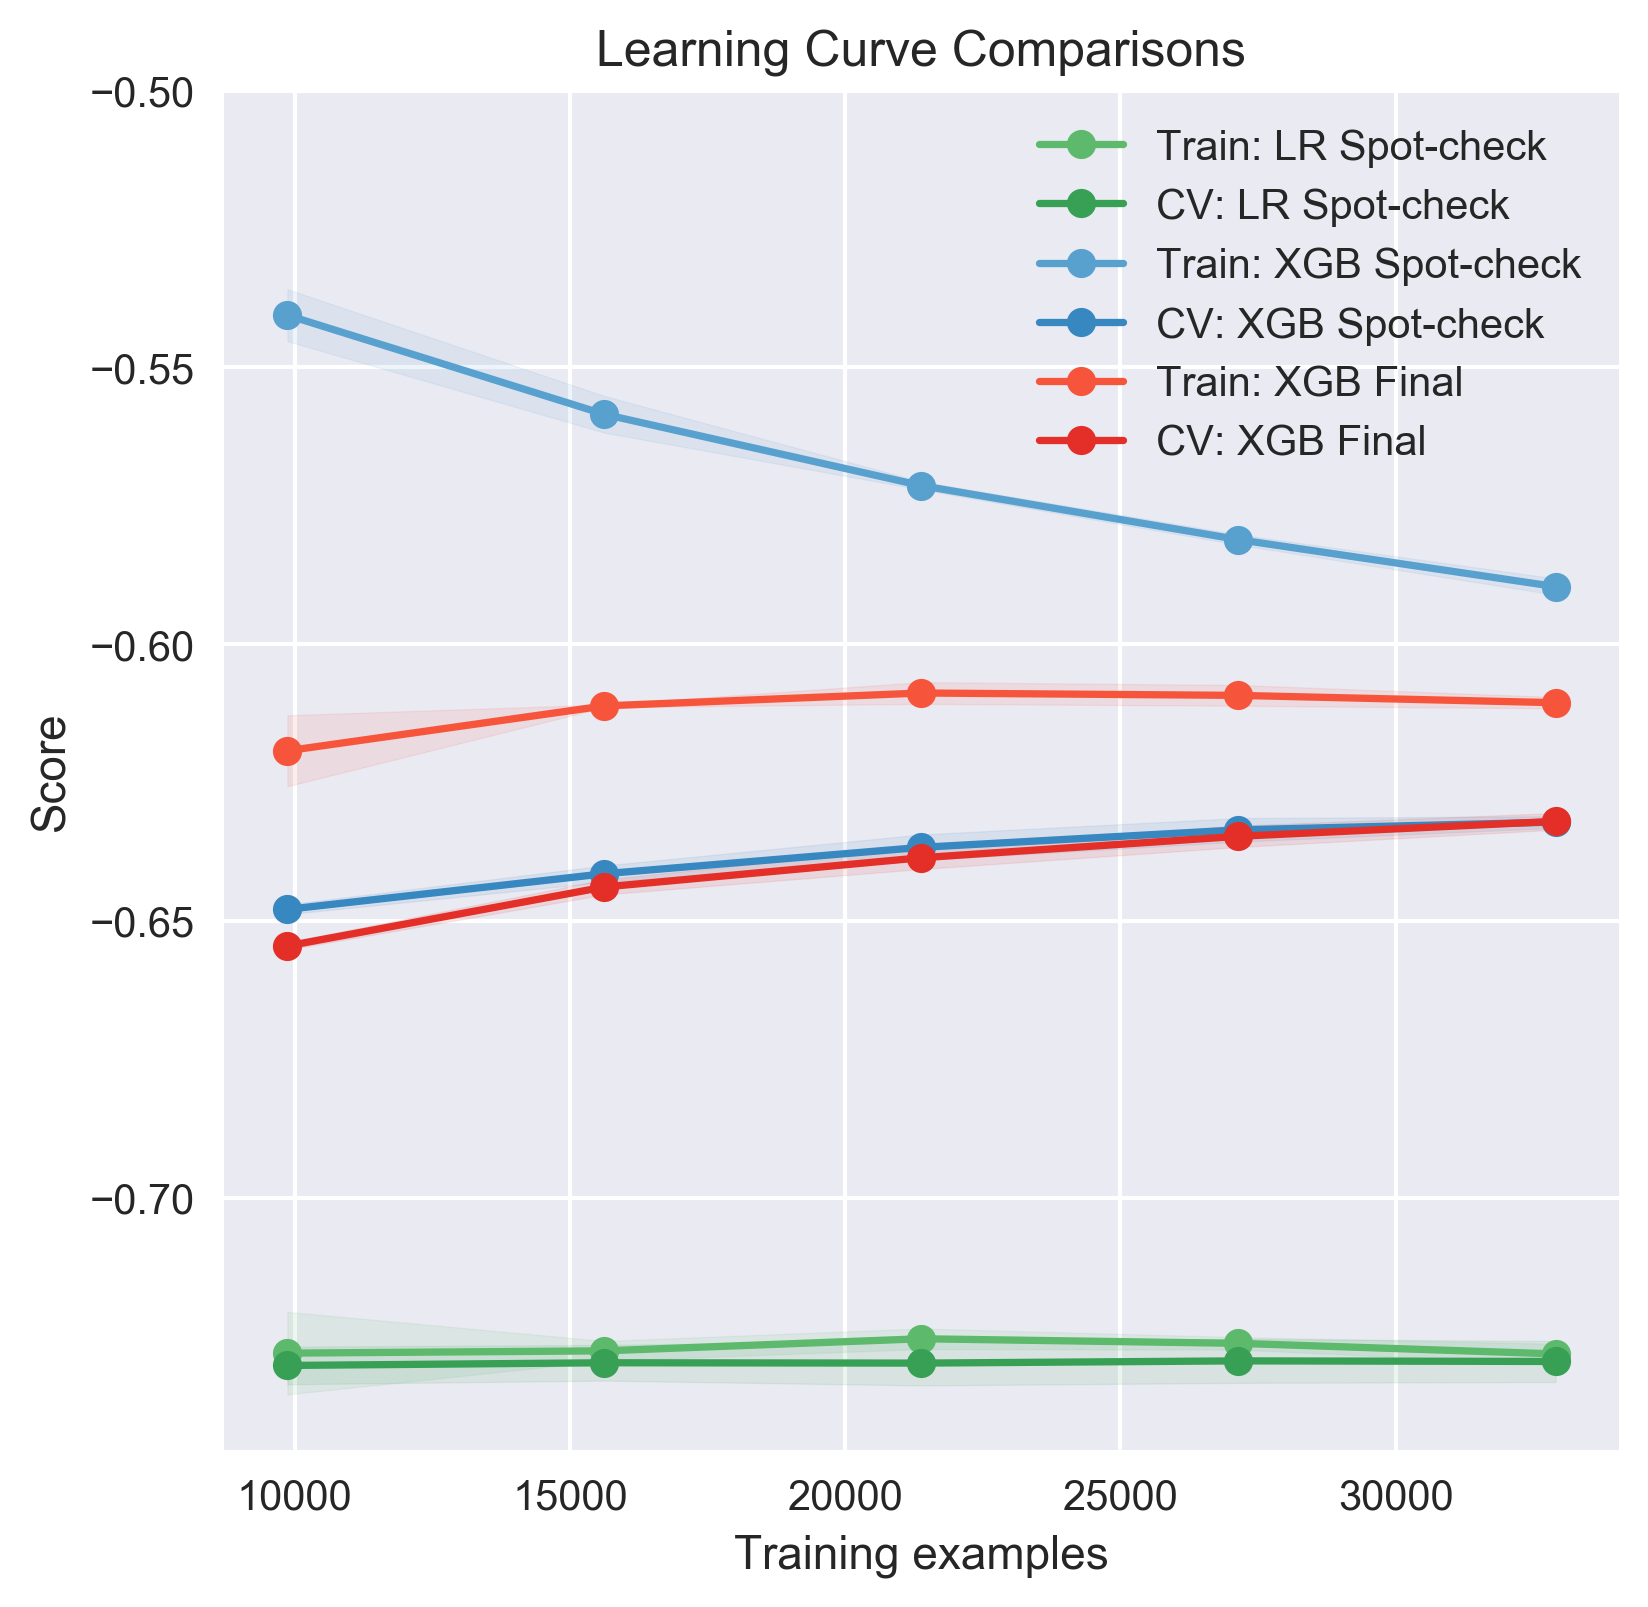

In [97]:
fp = ''.join([REPORT_IMG_DIR, 'justification-learning-curve.png'])

RUN_LEARNING_CURVE = False

if RUN_LEARNING_CURVE:
    lr_spot = joblib.load(SPOT_CHECK_LR_FP)
    xgb_spot = joblib.load(SPOT_CHECK_XGB_FP)
    xgb_final = joblib.load(FINAL_MODEL_FP)
    
    train_sizes = np.linspace(.3, 1.0, 5)
    
    fig, ax = plt.subplots(figsize=(6, 6))
    title = 'Learning Curve Comparisons'
    legend_labels = []
    
    start = time.time()
    plot_learning_curve(
        estimator=lr_spot, X=X_prepped, y=y, train_sizes=train_sizes,
        scoring=scoring, n_jobs=N_JOBS, ax=ax,
        train_color='#5db96b', cv_color='#37a055',  # greens
    )
    legend_labels += ['Train: LR Spot-check',
                      'CV: LR Spot-check']
    
    plot_learning_curve(
        estimator=xgb_spot, X=X_prepped, y=y, train_sizes=train_sizes,
        scoring=scoring, n_jobs=N_JOBS, ax=ax, 
        train_color='#58a1cf', cv_color='#3787c0',  # blues
    )
    legend_labels += ['Train: XGB Spot-check',
                      'CV: XGB Spot-check']
    
    plot_learning_curve(
        estimator=xgb_final, X=X_prepped, y=y, train_sizes=train_sizes,
        scoring=scoring, n_jobs=N_JOBS, ax=ax,
        train_color='#f6553c', cv_color='#e32f27',  # reds
    )
    legend_labels += ['Train: XGB Final',
                      'CV: XGB Final']
    
    end = time.time()
    
    print('Runtime: {}min {}s'.format(*to_min_secs(end-start)))
    
    plt.legend(legend_labels)
    plt.title(title)
    plt.ylim(top=-.5)
    
#     plt.savefig(fp, dpi=300, bbox_inches='tight')
    plt.show()

else:
    display(Image(fp, width=400))

Output:
```
Runtime: 2min 13s
```

# Conclusion

## Free-Form Visualization
- Same at refinement stage no. 2, less `colsample_bytree` dimension

Loaded: ./Models/grid_free_form.pkl
Best grid CV score: -0.6262 ± 0.0023 (mean ± std. dev.)
Train score:        -0.5777 ± 0.0022 (mean ± std. dev.)

*** For parameters: ***
gamma=1
max_depth=5


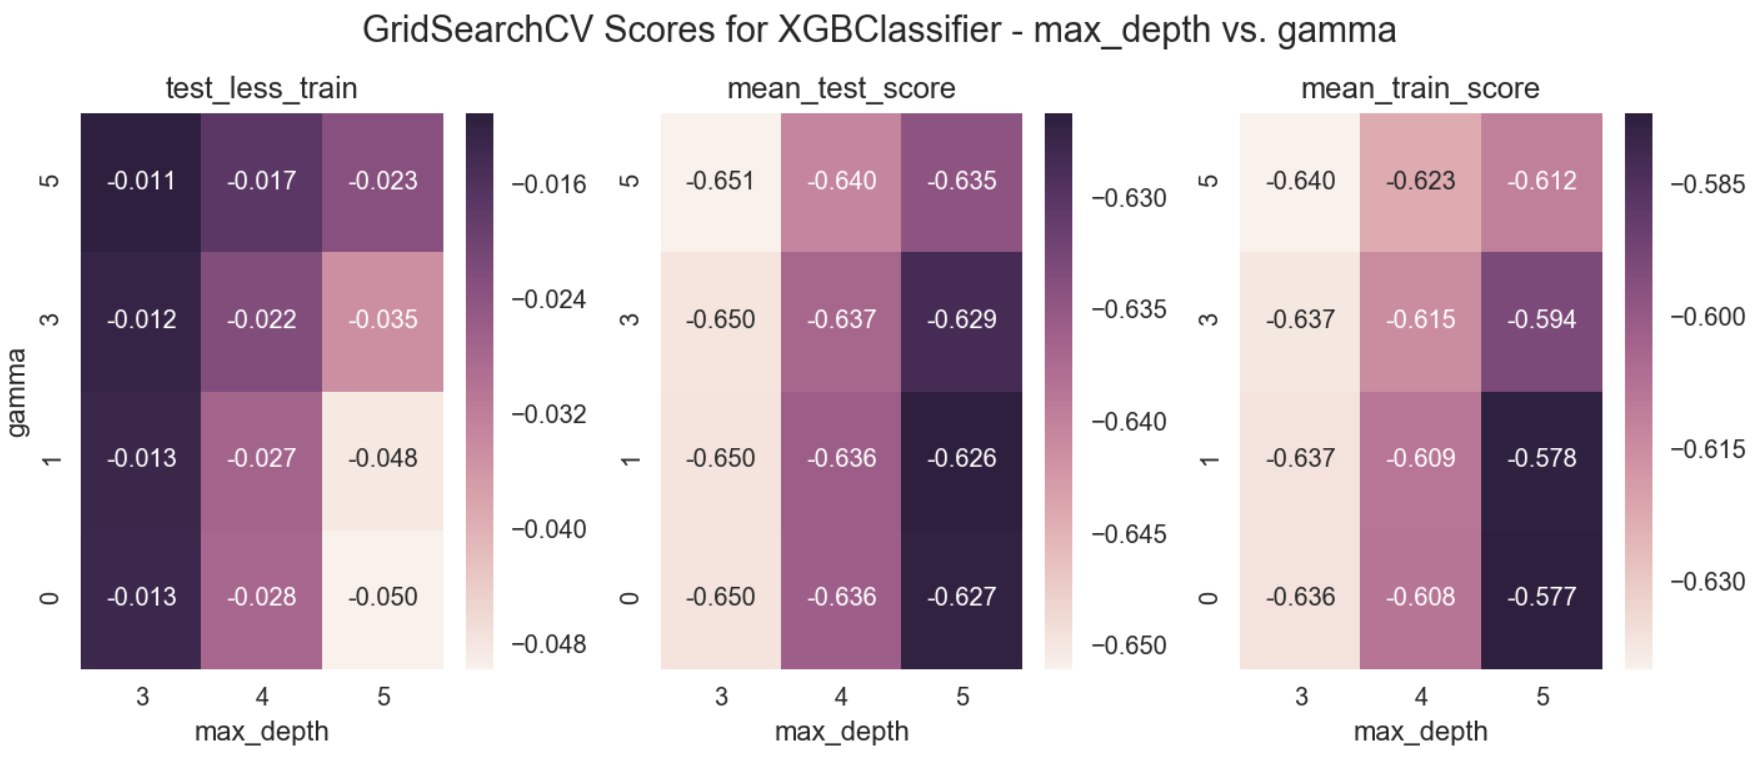

In [99]:
RUN_XGB = False

if RUN_XGB:
    
    # Same as for missing value evaluation
    learning_rate = 0.05
    n_estimators = 200
    
    max_depth = [3, 4, 5]
    gamma = [0, 1, 3, 5]
    
    xgb_clf = XGBClassifier(
        objective='multi:softprob',
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        
        missing=-999, nthread=1, seed=SEED,
        
    )
    params = dict(
        max_depth=max_depth,
        gamma=gamma,
    )
    
    fit_params=dict(
        early_stopping_rounds=3, 
        eval_metric='mlogloss', 
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=False,
    )
    grid_ff = GridSearchCV(xgb_clf, params, fit_params=fit_params,
                           scoring=scoring, cv=3, n_jobs=N_JOBS)

    %timeit -r1 -n1 grid_ff.fit(X_train, y_train)
    print()
    
#     joblib.dump(grid_ff, GRID_FREE_FORM_FP)
#     print('Pickled to: {}'.format(GRID_FREE_FORM_FP))
    
else:
    grid_ff = joblib.load(GRID_FREE_FORM_FP)
    print('Loaded: {}'.format(GRID_FREE_FORM_FP))

print(best_grid_score(grid_ff))    

fp = ''.join([REPORT_IMG_DIR, 'free-form-grid-plot.png'])
REPLOT = False
if REPLOT:
    ge = GridSearchExplorer(grid_ff)
    fig = ge.plot_cv_train_comparison(x='max_depth')

    suptitle = ('GridSearchCV Scores for XGBClassifier'
                ' - max_depth vs. gamma')
    plt.suptitle(suptitle, fontsize='x-large', y=1.05)

#     plt.savefig(fp, dpi=300, bbox_inches='tight')

    plt.tight_layout()
else:
    display(Image(fp, width=1000))

Output:
```
Loaded: ./Models/grid_free_form.pkl
2min 5s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)

Best grid CV score: -0.6262 ± 0.0023 (mean ± std. dev.)
Train score:        -0.5777 ± 0.0022 (mean ± std. dev.)

*** For parameters: ***
gamma=1
max_depth=5
```

# Feature Selection

From [StackEx](https://datascience.stackexchange.com/questions/12318/how-do-i-interpret-the-output-of-xgboost-importance): How do i interpret the output of XGBoost importance?

_Gain_: the relative contribution of the corresponding feature to the model calculated by taking each feature's contribution for each tree in the model
- A higher value of this metric when compared to another feature implies it is more important for generating a prediction.
- It is the most relevant attribute to interpret the relative importance of each feature.

_Weight_: (or fscore) is the percentage representing the relative number of times a particular feature occurs in the trees of the model. 
- In the above example, if feature1 occurred in 2 splits, 1 split and 3 splits in each of tree1, tree2 and tree3; then the weightage for feature1 will be 2+1+3 = 6.
- The frequency for feature1 is calculated as its percentage weight over weights of all features.

_Cover_: the relative number of observations related to this feature. 
- For example, if you have 100 observations, 4 features and 3 trees, and suppose feature1 is used to decide the leaf node for 10, 5, and 2 observations in tree1, tree2 and tree3 respectively; then the metric will count cover for this feature as 10+5+2 = 17 observations. 
- This will be calculated for all the 4 features and the cover will be 17 expressed as a percentage for all features' cover metrics.

In [44]:
def get_xgb_imp(xgb, feat_names):
    from numpy import array
    imp_vals = xgb.booster().get_fscore()
    imp_dict = {feat_names[i]:float(imp_vals.get('f'+str(i),0.)) for i in range(len(feat_names))}
    return imp_dict

imp_dict = get_xgb_imp(xgb_final, features)
feat_by_fscore = pd.Series(imp_dict).sort_values(ascending=False).index.tolist()


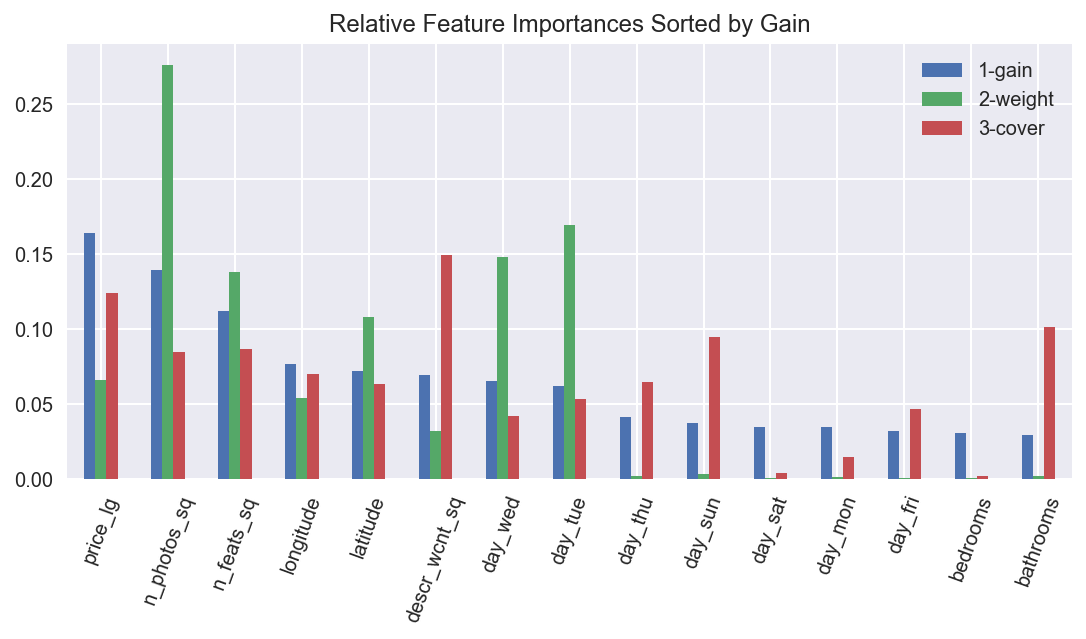

In [47]:
bst = xgb_final.booster()
score_dict = {}
for i, imp_type in enumerate(['gain', 'weight', 'cover'], 1):
    
    col_name = str(i)+'-'+imp_type  # For correct hue ordering
    score_dict[col_name] = bst.get_score(importance_type=imp_type)
feat_scores = (pd.DataFrame(score_dict)
                 .apply(lambda x: x/sum(x))
                 .sort_values('1-gain', ascending=False)
)
ax = feat_scores.plot(kind='bar', rot=70, figsize=(9, 4))
ax.set_title('Relative Feature Importances Sorted by Gain')
ax.set_xticklabels(feat_by_fscore)
plt.show()

In [48]:
GroupSumExtractor?

In [76]:
xgb_clf = XGBClassifier(
    objective='multi:softprob',
    learning_rate=0.1, n_estimators=120,
    subsample=0.8, colsample_bytree=0.8,
    missing=-999, nthread=NTHREAD, seed=SEED,
    max_depth=6, min_child_weight=1,
)

fit_params = dict(X=X_train, y=y_train, eval_metric='mlogloss',
                  eval_set=[(X_train, y_train), (X_test, y_test)],
                  verbose=False,
)
%timeit -r1 -n1 xgb_clf.fit(**fit_params)

23.3 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


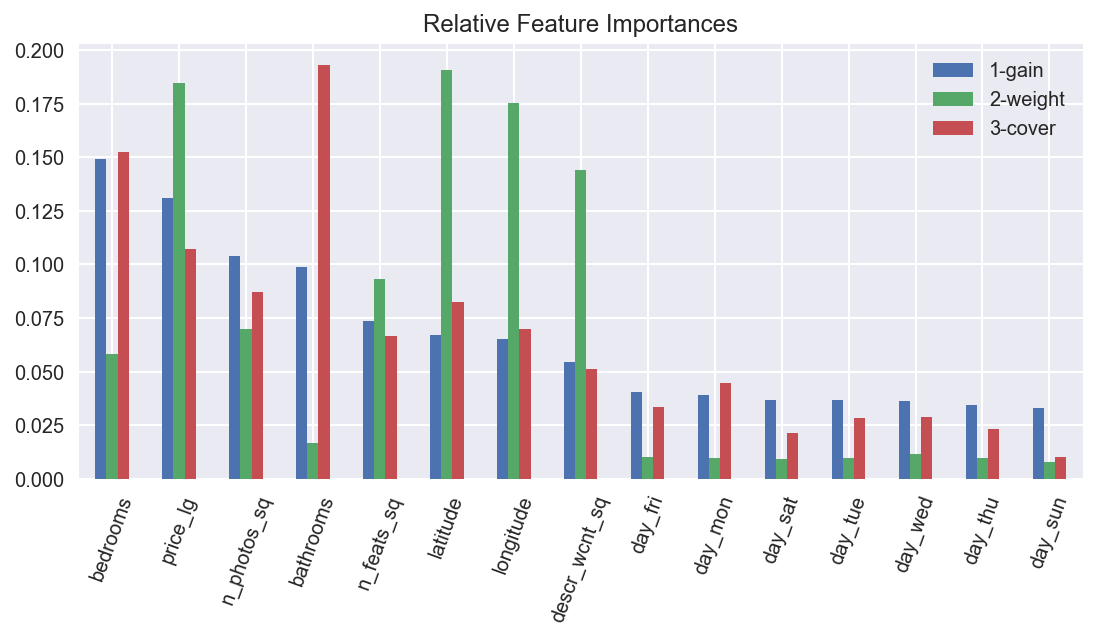

In [193]:
score_dict = {}
for i, imp_type in enumerate(['gain', 'weight', 'cover'], 1):
    
    col_name = str(i)+'-'+imp_type  # For correct hue ordering
    score_dict[col_name] = bst.get_score(importance_type=imp_type)
feat_scores = (pd.DataFrame(score_dict)
                 .apply(lambda x: x/sum(x))
                 .sort_values('1-gain', ascending=False)
)
ax = feat_scores.plot(kind='bar', rot=70, figsize=(9, 4))
ax.set_title('Relative Feature Importances')

plt.show()

# NLP

## Description

In [ ]:
words = Counter()

def extract_words(feats):
    feats = [re.sub(r'[ ]*[^\w ][ ]*', ' ', s.upper())
             for s in feats]
    words = [word for s in feats for word in s.split()]
    
    return words

In [ ]:
for idx, feats in df.features.iteritems():
    words.update(extract_words(feats))

In [ ]:
words.most_common()

In [ ]:
with open(TRAIN_FP) as f:
    x = f.read()
a = 10011000
x[a:a+540]

In [ ]:
s = 'itness gym, laundry facility & pet-friendly'

df[df.description.str.contains(s)].iat[0, 4]

- Strip:
    - leading spaces
    - html tags: `<br /><br />`
    - html entities?
    - returns: `\r`
    - weird separators
- Replace:
    - `w/ ` to `with`
    - `washer /dryer` and other unspaced slashes
    - `&` to `and`
- Separate words joined between sentences
    - e.g. `FloorsLimed Brick WallsPrivate BalconiesIntricate`
    - very important, lots of instances, spearate by caps
    - not possible when all caps
- Separate joined word without caps:
    - `Long Island Railroad isabout a 10 `

- New features:
    - Length of description
    - Has website (`website_redacted` or html tag)
    - Has email
    - Has phone number

